# Genetik Algoritma ile Nakliye Rotası Optimizasyonu

## Senaryo 3: Nakliye Rotasında Yakıt ve Zaman Dengesi

Bu projede, bir lojistik firmasının rota seçimi sırasında yakıt tüketimi ve süreyi optimize etmesi için genetik algoritma kullanılmaktadır.

### Problem Tanımı

**Amaç Fonksiyonu:**
$$y = -2x_1 - 3x_2 + 0.1x_1x_2$$

Bu fonksiyon negatif toplam maliyeti temsil eder. Maksimize etmek istiyoruz (yani maliyeti minimize etmek).

**Değişkenler:**
- $x_1$: Ortalama hız (km/h) → [40, 100]
- $x_2$: Araç yük kapasitesi (ton) → [2, 10]

**Kısıtlar:**
- $x_1 \times x_2 \leq 700$ (Motor gücü limiti)
- $x_1 \geq 60$ (Minimum hız şartı)


## 1. Kütüphanelerin İçe Aktarılması


In [31]:
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib import cm
import warnings
warnings.filterwarnings('ignore')

# Türkçe karakter desteği için
plt.rcParams['font.family'] = 'DejaVu Sans'
print("Kütüphaneler başarıyla yüklendi!")


Kütüphaneler başarıyla yüklendi!


## 2. Problem Parametrelerinin Tanımlanması


In [32]:
# Değişken sınırları
X1_MIN, X1_MAX = 40, 100  # Ortalama hız (km/h)
X2_MIN, X2_MAX = 2, 10     # Araç yük kapasitesi (ton)

# Kısıtlar
MOTOR_GUC_LIMIT = 700  # x1 * x2 <= 700
MIN_HIZ = 60           # x1 >= 60

print(f"Değişken sınırları:")
print(f"x1 (Hız): [{X1_MIN}, {X1_MAX}] km/h")
print(f"x2 (Yük): [{X2_MIN}, {X2_MAX}] ton")
print(f"\nKısıtlar:")
print(f"x1 * x2 <= {MOTOR_GUC_LIMIT}")
print(f"x1 >= {MIN_HIZ}")


Değişken sınırları:
x1 (Hız): [40, 100] km/h
x2 (Yük): [2, 10] ton

Kısıtlar:
x1 * x2 <= 700
x1 >= 60


## 3. Amaç Fonksiyonu ve Kısıt Kontrolü


In [33]:
def amac_fonksiyonu(x1, x2):
    """
    Amaç fonksiyonu: y = -2x1 - 3x2 + 0.1x1x2
    Negatif toplam maliyeti temsil eder.
    Maksimize etmek istiyoruz.
    """
    return -2 * x1 - 3 * x2 + 0.1 * x1 * x2

def kisit_kontrol(x1, x2):
    """
    Kısıtların sağlanıp sağlanmadığını kontrol eder.
    True dönerse kısıtlar sağlanıyor, False dönerse sağlanmıyor.
    """
    # Kısıt 1: x1 * x2 <= 700 (Motor gücü limiti)
    kisit1 = (x1 * x2) <= MOTOR_GUC_LIMIT
    
    # Kısıt 2: x1 >= 60 (Minimum hız şartı)
    kisit2 = x1 >= MIN_HIZ
    
    return kisit1 and kisit2

# Test
test_x1, test_x2 = 70, 8
print(f"Test değerleri: x1={test_x1}, x2={test_x2}")
print(f"Amaç fonksiyonu değeri: {amac_fonksiyonu(test_x1, test_x2):.2f}")
print(f"Kısıt kontrolü: {kisit_kontrol(test_x1, test_x2)}")


Test değerleri: x1=70, x2=8
Amaç fonksiyonu değeri: -108.00
Kısıt kontrolü: True


## 4. Genetik Algoritma Parametreleri


In [34]:
# Genetik algoritma parametreleri
POPULASYON_BOYUTU = 50      # Popülasyondaki birey sayısı
MAX_NESIL = 100             # Maksimum nesil sayısı
CROSSOVER_ORANI = 0.8       # Çaprazlama olasılığı
MUTASYON_ORANI = 0.1        # Mutasyon olasılığı
TURNUVA_BOYUTU = 3          # Turnuva seçilimi için turnuva boyutu
ELITIZM_SAYISI = 2          # Her nesilde korunacak en iyi birey sayısı

print(f"Genetik Algoritma Parametreleri:")
print(f"Popülasyon Boyutu: {POPULASYON_BOYUTU}")
print(f"Maksimum Nesil: {MAX_NESIL}")
print(f"Çaprazlama Oranı: {CROSSOVER_ORANI}")
print(f"Mutasyon Oranı: {MUTASYON_ORANI}")
print(f"Turnuva Boyutu: {TURNUVA_BOYUTU}")
print(f"Elitizm Sayısı: {ELITIZM_SAYISI}")


Genetik Algoritma Parametreleri:
Popülasyon Boyutu: 50
Maksimum Nesil: 100
Çaprazlama Oranı: 0.8
Mutasyon Oranı: 0.1
Turnuva Boyutu: 3
Elitizm Sayısı: 2


## 5. Birey ve Popülasyon Tanımları


In [35]:
class Birey:
    """
    Her birey iki gen içerir: x1 (hız) ve x2 (yük kapasitesi)
    """
    def __init__(self, x1=None, x2=None):
        if x1 is None:
            # Rastgele başlangıç değerleri (kısıtlar içinde)
            # x1 >= 60 kısıtını sağlayacak şekilde
            self.x1 = random.uniform(max(X1_MIN, MIN_HIZ), X1_MAX)
            # x2 değeri, x1 ile birlikte motor gücü kısıtını sağlamalı
            max_x2 = min(X2_MAX, MOTOR_GUC_LIMIT / self.x1)
            self.x2 = random.uniform(X2_MIN, max_x2)
        else:
            self.x1 = x1
            self.x2 = x2
        
        # Kısıtları sağlamayan bireyleri düzelt
        self.duzelt()
        
        # Fitness değerini hesapla
        self.fitness = self.fitness_hesapla()
    
    def duzelt(self):
        """
        Bireyin kısıtları sağlamasını garanti eder.
        """
        # Sınırları kontrol et
        self.x1 = max(X1_MIN, min(X1_MAX, self.x1))
        self.x2 = max(X2_MIN, min(X2_MAX, self.x2))
        
        # Minimum hız kısıtı
        if self.x1 < MIN_HIZ:
            self.x1 = MIN_HIZ
        
        # Motor gücü kısıtı
        if self.x1 * self.x2 > MOTOR_GUC_LIMIT:
            # x2'yi azalt
            self.x2 = min(self.x2, MOTOR_GUC_LIMIT / self.x1)
            self.x2 = max(X2_MIN, self.x2)
    
    def fitness_hesapla(self):
        """
        Fitness değerini hesaplar.
        Kısıtları sağlamayan bireylere ceza verir.
        """
        # Kısıt kontrolü
        if not kisit_kontrol(self.x1, self.x2):
            return -10000  # Çok düşük fitness (ceza)
        
        # Amaç fonksiyonu değeri (maksimize etmek istiyoruz)
        return amac_fonksiyonu(self.x1, self.x2)
    
    def __repr__(self):
        return f"Birey(x1={self.x1:.2f}, x2={self.x2:.2f}, fitness={self.fitness:.2f})"

# Test
test_birey = Birey()
print(f"Örnek birey: {test_birey}")
print(f"Kısıt kontrolü: {kisit_kontrol(test_birey.x1, test_birey.x2)}")


Örnek birey: Birey(x1=98.25, x2=4.47, fitness=-166.00)
Kısıt kontrolü: True


## 6. Popülasyon Oluşturma


In [36]:
def populasyon_olustur(boyut):
    """
    Rastgele bireylerden oluşan bir popülasyon oluşturur.
    """
    return [Birey() for _ in range(boyut)]

# İlk popülasyonu oluştur
populasyon = populasyon_olustur(POPULASYON_BOYUTU)
print(f"Popülasyon oluşturuldu: {len(populasyon)} birey")
print(f"\nİlk 5 birey:")
for i, birey in enumerate(populasyon[:5]):
    print(f"{i+1}. {birey}")


Popülasyon oluşturuldu: 50 birey

İlk 5 birey:
1. Birey(x1=61.36, x2=7.33, fitness=-99.73)
2. Birey(x1=67.33, x2=3.52, fitness=-121.51)
3. Birey(x1=66.80, x2=3.43, fitness=-120.96)
4. Birey(x1=65.91, x2=4.52, fitness=-115.58)
5. Birey(x1=79.42, x2=3.38, fitness=-142.16)


## 7. Seçilim Mekanizması (Turnuva Seçilimi)


In [37]:
def turnuva_secimi(populasyon, turnuva_boyutu):
    """
    Turnuva seçilimi: Rastgele seçilen bireyler arasından en iyisini seçer.
    Bu yöntem genetik çeşitliliği korurken iyi bireyleri de seçer.
    """
    turnuva = random.sample(populasyon, turnuva_boyutu)
    # En yüksek fitness değerine sahip bireyi seç
    return max(turnuva, key=lambda b: b.fitness)

# Test
secilen = turnuva_secimi(populasyon, TURNUVA_BOYUTU)
print(f"Turnuva seçilimi ile seçilen birey: {secilen}")


Turnuva seçilimi ile seçilen birey: Birey(x1=68.13, x2=3.87, fitness=-121.51)


## 8. Çaprazlama (Crossover) Operatörü


In [38]:
def caprazlama(ebeveyn1, ebeveyn2):
    """
    İki ebeveynden yeni bir çocuk birey oluşturur.
    Aritmetik çaprazlama kullanılır.
    """
    # Aritmetik çaprazlama: çocuk = alpha * ebeveyn1 + (1-alpha) * ebeveyn2
    alpha = random.random()
    
    yeni_x1 = alpha * ebeveyn1.x1 + (1 - alpha) * ebeveyn2.x1
    yeni_x2 = alpha * ebeveyn1.x2 + (1 - alpha) * ebeveyn2.x2
    
    # Yeni birey oluştur (duzelt() metodu kısıtları kontrol edecek)
    cocuk = Birey(yeni_x1, yeni_x2)
    
    return cocuk

# Test
ebeveyn1 = populasyon[0]
ebeveyn2 = populasyon[1]
cocuk = caprazlama(ebeveyn1, ebeveyn2)
print(f"Ebeveyn 1: {ebeveyn1}")
print(f"Ebeveyn 2: {ebeveyn2}")
print(f"Çocuk: {cocuk}")


Ebeveyn 1: Birey(x1=61.36, x2=7.33, fitness=-99.73)
Ebeveyn 2: Birey(x1=67.33, x2=3.52, fitness=-121.51)
Çocuk: Birey(x1=66.79, x2=3.87, fitness=-119.32)


## 9. Mutasyon Operatörü


In [39]:
def mutasyon(birey, mutasyon_orani):
    """
    Bireyin genlerine rastgele değişiklik uygular.
    Genetik çeşitliliği artırır ve yerel optimumlardan kaçınmayı sağlar.
    """
    if random.random() < mutasyon_orani:
        # x1 için mutasyon
        if random.random() < 0.5:
            # Rastgele bir değer ekle (sınırlar içinde)
            degisim = random.uniform(-10, 10)
            birey.x1 = max(max(X1_MIN, MIN_HIZ), min(X1_MAX, birey.x1 + degisim))
        
        # x2 için mutasyon
        if random.random() < 0.5:
            degisim = random.uniform(-1, 1)
            birey.x2 = max(X2_MIN, min(X2_MAX, birey.x2 + degisim))
        
        # Kısıtları tekrar kontrol et ve düzelt
        birey.duzelt()
        # Fitness'ı yeniden hesapla
        birey.fitness = birey.fitness_hesapla()
    
    return birey

# Test
test_birey_mut = Birey(70, 8)
print(f"Mutasyon öncesi: {test_birey_mut}")
mutasyon(test_birey_mut, 1.0)  # Kesinlikle mutasyon uygula
print(f"Mutasyon sonrası: {test_birey_mut}")


Mutasyon öncesi: Birey(x1=70.00, x2=8.00, fitness=-108.00)
Mutasyon sonrası: Birey(x1=69.60, x2=8.48, fitness=-105.62)


## 10. Elitizm: En İyi Bireyleri Koruma


In [40]:
def en_iyi_bireyleri_sec(populasyon, sayi):
    """
    Popülasyondan en iyi (en yüksek fitness) bireyleri seçer.
    Elitizm için kullanılır.
    """
    # Fitness'a göre sırala ve en iyileri al
    sirali = sorted(populasyon, key=lambda b: b.fitness, reverse=True)
    return sirali[:sayi]

# Test
en_iyiler = en_iyi_bireyleri_sec(populasyon, 3)
print("En iyi 3 birey:")
for i, birey in enumerate(en_iyiler):
    print(f"{i+1}. {birey}")


En iyi 3 birey:
1. Birey(x1=61.36, x2=7.33, fitness=-99.73)
2. Birey(x1=66.84, x2=9.15, fitness=-99.97)
3. Birey(x1=64.24, x2=8.23, fitness=-100.30)


## 11. Genetik Algoritma Ana Döngüsü


In [41]:
def genetik_algoritma_calistir():
    """
    Genetik algoritmanın ana döngüsünü çalıştırır.
    """
    # İlk popülasyonu oluştur
    populasyon = populasyon_olustur(POPULASYON_BOYUTU)
    
    # Sonuçları takip et
    en_iyi_fitness_gecmisi = []
    ortalama_fitness_gecmisi = []
    en_iyi_birey_gecmisi = []
    
    print("Genetik Algoritma başlatılıyor...")
    print(f"Popülasyon boyutu: {POPULASYON_BOYUTU}, Maksimum nesil: {MAX_NESIL}\n")
    
    for nesil in range(MAX_NESIL):
        # En iyi bireyi bul
        en_iyi_birey = max(populasyon, key=lambda b: b.fitness)
        en_iyi_fitness = en_iyi_birey.fitness
        
        # Ortalama fitness
        ortalama_fitness = sum(b.fitness for b in populasyon) / len(populasyon)
        
        # Geçmişi kaydet
        en_iyi_fitness_gecmisi.append(en_iyi_fitness)
        ortalama_fitness_gecmisi.append(ortalama_fitness)
        en_iyi_birey_gecmisi.append((en_iyi_birey.x1, en_iyi_birey.x2, en_iyi_fitness))
        
        # Her 10 nesilde bir ilerlemeyi göster
        if (nesil + 1) % 10 == 0 or nesil == 0:
            print(f"Nesil {nesil + 1}/{MAX_NESIL}: "
                  f"En iyi fitness = {en_iyi_fitness:.4f}, "
                  f"Ortalama fitness = {ortalama_fitness:.4f}, "
                  f"x1 = {en_iyi_birey.x1:.2f}, x2 = {en_iyi_birey.x2:.2f}")
        
        # Yeni popülasyon oluştur
        yeni_populasyon = []
        
        # Elitizm: En iyi bireyleri koru
        elitistler = en_iyi_bireyleri_sec(populasyon, ELITIZM_SAYISI)
        yeni_populasyon.extend([Birey(elit.x1, elit.x2) for elit in elitistler])
        
        # Kalan bireyleri üret
        while len(yeni_populasyon) < POPULASYON_BOYUTU:
            # Seçilim
            ebeveyn1 = turnuva_secimi(populasyon, TURNUVA_BOYUTU)
            ebeveyn2 = turnuva_secimi(populasyon, TURNUVA_BOYUTU)
            
            # Çaprazlama
            if random.random() < CROSSOVER_ORANI:
                cocuk = caprazlama(ebeveyn1, ebeveyn2)
            else:
                # Çaprazlama yoksa, ebeveynlerden birini kopyala
                cocuk = Birey(ebeveyn1.x1, ebeveyn1.x2) if random.random() < 0.5 else Birey(ebeveyn2.x1, ebeveyn2.x2)
            
            # Mutasyon
            cocuk = mutasyon(cocuk, MUTASYON_ORANI)
            
            yeni_populasyon.append(cocuk)
        
        # Yeni popülasyonu eski popülasyonun yerine koy
        populasyon = yeni_populasyon
    
    # Final en iyi birey
    final_en_iyi = max(populasyon, key=lambda b: b.fitness)
    
    print(f"\nOptimizasyon tamamlandı!")
    print(f"En iyi çözüm:")
    print(f"  x1 (Hız) = {final_en_iyi.x1:.4f} km/h")
    print(f"  x2 (Yük) = {final_en_iyi.x2:.4f} ton")
    print(f"  Fitness (Amaç fonksiyonu) = {final_en_iyi.fitness:.4f}")
    print(f"  Kısıt kontrolü: {kisit_kontrol(final_en_iyi.x1, final_en_iyi.x2)}")
    
    return final_en_iyi, en_iyi_fitness_gecmisi, ortalama_fitness_gecmisi, en_iyi_birey_gecmisi

# Algoritmayı çalıştır
en_iyi_cozum, fitness_gecmisi, ortalama_gecmisi, birey_gecmisi = genetik_algoritma_calistir()


Genetik Algoritma başlatılıyor...
Popülasyon boyutu: 50, Maksimum nesil: 100

Nesil 1/100: En iyi fitness = -93.1908, Ortalama fitness = -131.3862, x1 = 61.46, x2 = 9.45
Nesil 10/100: En iyi fitness = -90.5155, Ortalama fitness = -91.3927, x1 = 60.00, x2 = 9.83
Nesil 20/100: En iyi fitness = -90.0000, Ortalama fitness = -90.1228, x1 = 60.00, x2 = 10.00
Nesil 30/100: En iyi fitness = -90.0000, Ortalama fitness = -90.0089, x1 = 60.00, x2 = 10.00
Nesil 40/100: En iyi fitness = -90.0000, Ortalama fitness = -90.0000, x1 = 60.00, x2 = 10.00
Nesil 50/100: En iyi fitness = -90.0000, Ortalama fitness = -90.1554, x1 = 60.00, x2 = 10.00
Nesil 60/100: En iyi fitness = -90.0000, Ortalama fitness = -90.0471, x1 = 60.00, x2 = 10.00
Nesil 70/100: En iyi fitness = -90.0000, Ortalama fitness = -90.0124, x1 = 60.00, x2 = 10.00
Nesil 80/100: En iyi fitness = -90.0000, Ortalama fitness = -90.1321, x1 = 60.00, x2 = 10.00
Nesil 90/100: En iyi fitness = -90.0000, Ortalama fitness = -90.0000, x1 = 60.00, x2 = 

## 12. Sonuçların Görselleştirilmesi


### 12.1. Fitness Değerlerinin Evrimi


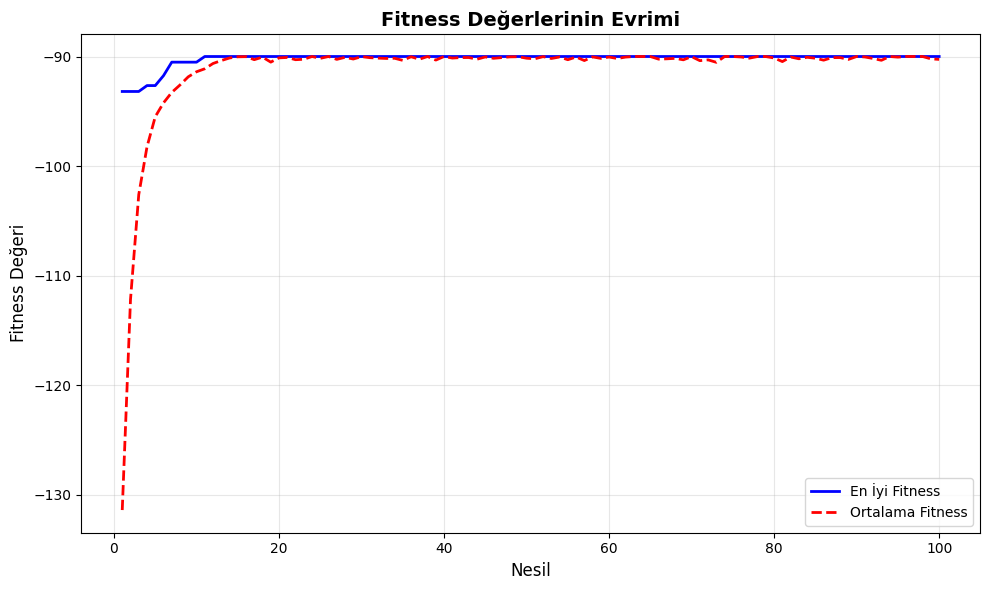

In [42]:
plt.figure(figsize=(10, 6))

plt.plot(range(1, len(fitness_gecmisi) + 1), fitness_gecmisi, 'b-', linewidth=2, label='En İyi Fitness')
plt.plot(range(1, len(ortalama_gecmisi) + 1), ortalama_gecmisi, 'r--', linewidth=2, label='Ortalama Fitness')
plt.xlabel('Nesil', fontsize=12)
plt.ylabel('Fitness Değeri', fontsize=12)
plt.title('Fitness Değerlerinin Evrimi', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 12.2. Değişkenlerin Evrimi


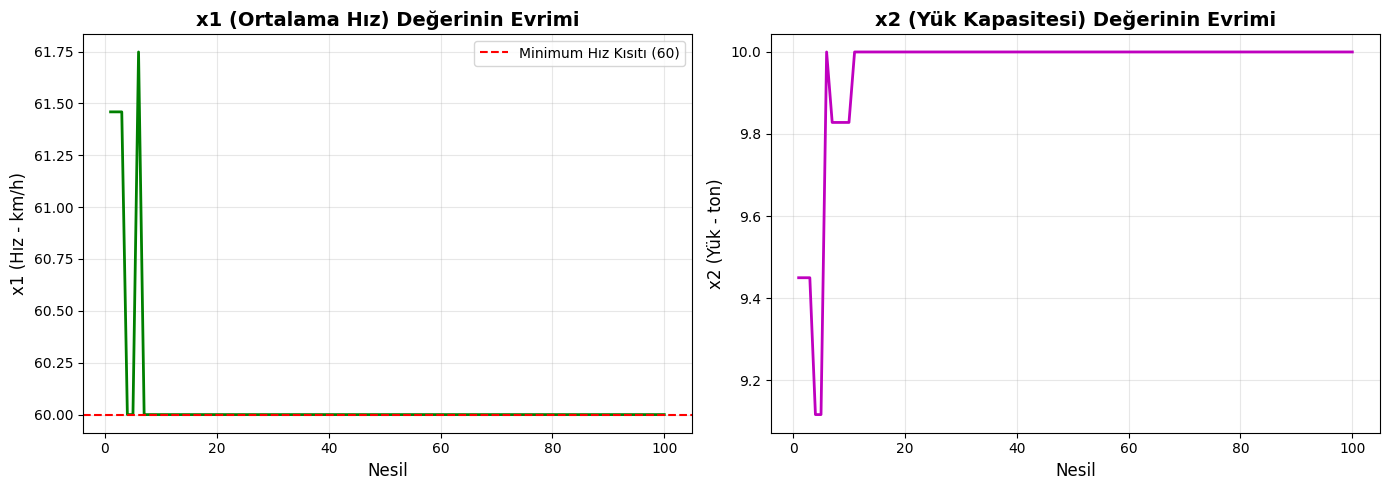

In [43]:
x1_gecmisi = [b[0] for b in birey_gecmisi]
x2_gecmisi = [b[1] for b in birey_gecmisi]

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(x1_gecmisi) + 1), x1_gecmisi, 'g-', linewidth=2)
plt.xlabel('Nesil', fontsize=12)
plt.ylabel('x1 (Hız - km/h)', fontsize=12)
plt.title('x1 (Ortalama Hız) Değerinin Evrimi', fontsize=14, fontweight='bold')
plt.axhline(y=MIN_HIZ, color='r', linestyle='--', label=f'Minimum Hız Kısıtı ({MIN_HIZ})')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(x2_gecmisi) + 1), x2_gecmisi, 'm-', linewidth=2)
plt.xlabel('Nesil', fontsize=12)
plt.ylabel('x2 (Yük - ton)', fontsize=12)
plt.title('x2 (Yük Kapasitesi) Değerinin Evrimi', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 12.3. Çözüm Yolunun Görselleştirilmesi


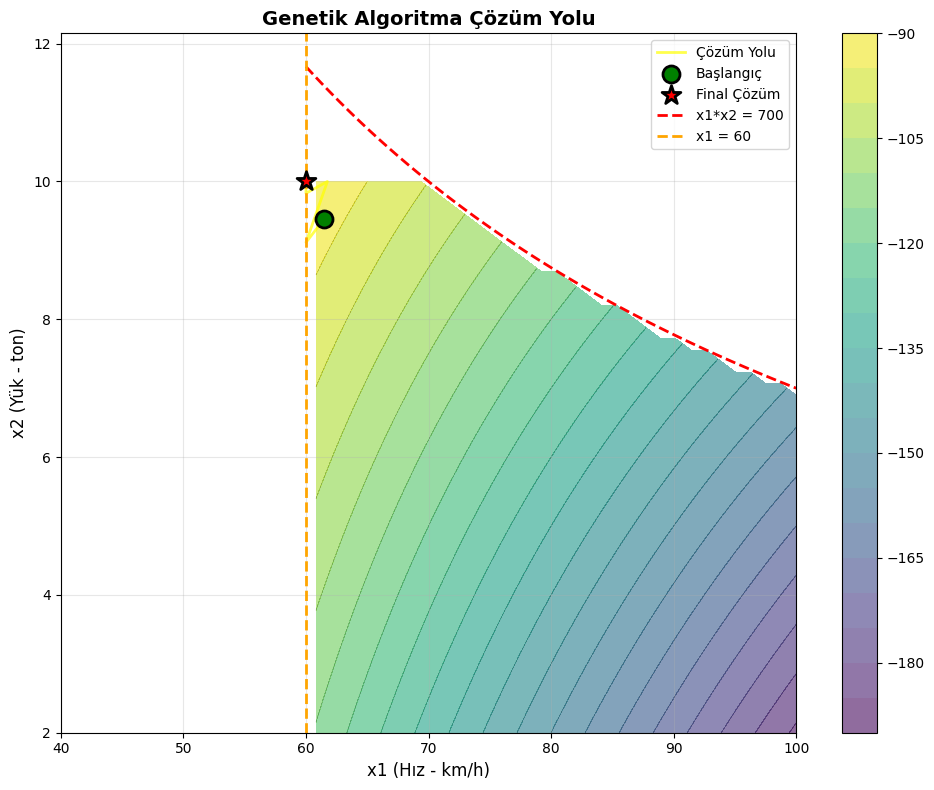

In [44]:
# İlk 50 nesil için çözüm yolunu göster
gosterilecek_nesil = min(50, len(birey_gecmisi))

# Mesh değişkenlerini tanımla
x1_range = np.linspace(X1_MIN, X1_MAX, 50)
x2_range = np.linspace(X2_MIN, X2_MAX, 50)
X1_mesh, X2_mesh = np.meshgrid(x1_range, x2_range)

# Amaç fonksiyonu değerlerini hesapla
Y_mesh = amac_fonksiyonu(X1_mesh, X2_mesh)

# Kısıt bölgesini belirle
kisit_maskesi = (X1_mesh * X2_mesh <= MOTOR_GUC_LIMIT) & (X1_mesh >= MIN_HIZ)
Y_mesh_kisitli = np.where(kisit_maskesi, Y_mesh, np.nan)

plt.figure(figsize=(10, 8))

# Kontur grafiği
contour = plt.contourf(X1_mesh, X2_mesh, Y_mesh_kisitli, levels=20, cmap=cm.viridis, alpha=0.6)
plt.contour(X1_mesh, X2_mesh, Y_mesh_kisitli, levels=20, colors='black', alpha=0.3, linewidths=0.5)

# Çözüm yolunu çiz
x1_yol = x1_gecmisi[:gosterilecek_nesil]
x2_yol = x2_gecmisi[:gosterilecek_nesil]
plt.plot(x1_yol, x2_yol, 'yellow', linewidth=2, alpha=0.7, label='Çözüm Yolu')
plt.scatter(x1_yol[0], x2_yol[0], color='green', s=150, marker='o', 
            label='Başlangıç', zorder=5, edgecolors='black', linewidths=2)
plt.scatter(x1_yol[-1], x2_yol[-1], color='red', s=200, marker='*', 
            label='Final Çözüm', zorder=5, edgecolors='black', linewidths=2)

# Kısıt çizgileri
x1_kisit = np.linspace(MIN_HIZ, X1_MAX, 100)
x2_kisit = MOTOR_GUC_LIMIT / x1_kisit
plt.plot(x1_kisit, x2_kisit, 'r--', linewidth=2, label=f'x1*x2 = {MOTOR_GUC_LIMIT}')
plt.axvline(x=MIN_HIZ, color='orange', linestyle='--', linewidth=2, label=f'x1 = {MIN_HIZ}')

plt.xlabel('x1 (Hız - km/h)', fontsize=12)
plt.ylabel('x2 (Yük - ton)', fontsize=12)
plt.title('Genetik Algoritma Çözüm Yolu', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.colorbar(contour)

plt.tight_layout()
plt.show()


## 13. Sonuçların Analizi ve Yorumu


In [45]:
print("=" * 60)
print("OPTİMİZASYON SONUÇLARI")
print("=" * 60)
print(f"\nEn İyi Çözüm:")
print(f"  • Ortalama Hız (x1): {en_iyi_cozum.x1:.4f} km/h")
print(f"  • Yük Kapasitesi (x2): {en_iyi_cozum.x2:.4f} ton")
print(f"  • Amaç Fonksiyonu Değeri: {en_iyi_cozum.fitness:.4f}")
print(f"  • Negatif Toplam Maliyet: {en_iyi_cozum.fitness:.4f}")

print(f"\nKısıt Kontrolleri:")
print(f"  • Motor Gücü Kısıtı (x1 * x2 <= {MOTOR_GUC_LIMIT}): {en_iyi_cozum.x1 * en_iyi_cozum.x2:.4f} <= {MOTOR_GUC_LIMIT} ✓")
print(f"  • Minimum Hız Kısıtı (x1 >= {MIN_HIZ}): {en_iyi_cozum.x1:.4f} >= {MIN_HIZ} ✓")

print(f"\nYorum:")
print(f"Genetik algoritma, verilen kısıtlar altında amaç fonksiyonunu optimize etmiştir.")
print(f"En iyi çözüm, {en_iyi_cozum.x1:.2f} km/h hız ve {en_iyi_cozum.x2:.2f} ton yük kapasitesi")
print(f"ile {en_iyi_cozum.fitness:.4f} değerinde bir negatif maliyet (yani minimum maliyet) sağlamıştır.")

print(f"\nAlgoritma Performansı:")
print(f"  • Toplam Nesil Sayısı: {MAX_NESIL}")
print(f"  • Popülasyon Boyutu: {POPULASYON_BOYUTU}")
print(f"  • İlk Nesil En İyi Fitness: {fitness_gecmisi[0]:.4f}")
print(f"  • Son Nesil En İyi Fitness: {fitness_gecmisi[-1]:.4f}")
print(f"  • İyileşme: {fitness_gecmisi[-1] - fitness_gecmisi[0]:.4f}")
print(f"  • İyileşme Yüzdesi: {((fitness_gecmisi[-1] - fitness_gecmisi[0]) / abs(fitness_gecmisi[0]) * 100):.2f}%")

print("\n" + "=" * 60)


OPTİMİZASYON SONUÇLARI

En İyi Çözüm:
  • Ortalama Hız (x1): 60.0000 km/h
  • Yük Kapasitesi (x2): 10.0000 ton
  • Amaç Fonksiyonu Değeri: -90.0000
  • Negatif Toplam Maliyet: -90.0000

Kısıt Kontrolleri:
  • Motor Gücü Kısıtı (x1 * x2 <= 700): 600.0000 <= 700 ✓
  • Minimum Hız Kısıtı (x1 >= 60): 60.0000 >= 60 ✓

Yorum:
Genetik algoritma, verilen kısıtlar altında amaç fonksiyonunu optimize etmiştir.
En iyi çözüm, 60.00 km/h hız ve 10.00 ton yük kapasitesi
ile -90.0000 değerinde bir negatif maliyet (yani minimum maliyet) sağlamıştır.

Algoritma Performansı:
  • Toplam Nesil Sayısı: 100
  • Popülasyon Boyutu: 50
  • İlk Nesil En İyi Fitness: -93.1908
  • Son Nesil En İyi Fitness: -90.0000
  • İyileşme: 3.1908
  • İyileşme Yüzdesi: 3.42%



## 14. Özet ve Sonuçlar

Bu projede, genetik algoritma kullanılarak nakliye rotası optimizasyon problemi çözülmüştür.

### Uygulanan Genetik Algoritma Bileşenleri:

1. **Popülasyon Tanımı**: Her birey iki gen içerir (x1: hız, x2: yük kapasitesi)
2. **Fitness Fonksiyonu**: Amaç fonksiyonu değeri, kısıt ihlalleri için ceza ile
3. **Seçilim**: Turnuva seçilimi (genetik çeşitliliği korur)
4. **Çaprazlama**: Aritmetik çaprazlama (ebeveynlerin özelliklerini birleştirir)
5. **Mutasyon**: Rastgele gen değişiklikleri (yerel optimumlardan kaçınma)
6. **Elitizm**: En iyi bireyleri koruma (çözüm kalitesini garanti eder)

### Sonuçlar:

Genetik algoritma, verilen kısıtlar altında amaç fonksiyonunu başarıyla optimize etmiştir. 
Algoritma, popülasyon boyutu, çaprazlama ve mutasyon oranları gibi parametreler ayarlanarak 
daha iyi sonuçlar elde edilebilir.
